In [2]:
import cv2
import os
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
print(os.getcwd())

d:\Side_projects\DFU\diabetic-foot-ulcer-assignment\code


#### Manually remove 2 non-informative data and some duplicated data:
- foot-wound-other-wound-split\foot-wound\698745687576686280.jpg
- foot-wound-other-wound-split\foot-wound\5413851144773139443.jpg

#### Observe count of each group to see if we have following issue:

- Imbalance
- Different data dimension

In [55]:
folder_names = ["../foot-wound-healthy-skin-split", "../foot-wound-other-wound-split"]

file_paths = []
groups = []

for folder_name in folder_names:
    group = defaultdict(list)
    for root, dir, files in os.walk(folder_name):
        for f in files:
            f = f.lower()
            if f.endswith("jpg") or f.endswith("png") or f.endswith("jpeg"):
                key = root.split("\\")[-1]
                group[key].append(os.path.join(root, f))
                file_paths.append(os.path.join(root, f))
    groups.append(group)

for group in groups:
    for k, v in group.items():
        print(f"{k} has size: {len(v)}")
      


healthy-skin has size: 503
ulcer has size: 512
foot-wound has size: 606
other-wound has size: 684


#### Get information like aspect ratios, w_hats, h_hats. Try to find the MLE.

##### Aspect Ratios

- Data size from skin group got aspect ratio=1
- Data size from foot group got aspect ratio=1.89 and 1.76 

In [56]:
# key = "foot-wound" # 45, 1.755 | 510, 1.8735
# key = "other-wound" # 598, 1.69 | 85, 2.166
def get_data_size(group, h_thres=0):
    
    bin_width = 100
    res = {}
    ratio_dict = {}
    for k, file_paths in group.items():
        count = 0
        ratio_sum = 0
        print("="*50)
        print(f"k={k}")
        print(len(file_paths))
        datasize_collections = defaultdict(list)
        for f in file_paths:
            img = cv2.imread(f)
            h, w, c = img.shape
            w = w//bin_width
            h = h//bin_width
            if h < w:
                h, w = w, h
                
            shape = (h, w)    
            if h > h_thres:
                ratio_sum += shape[0]/shape[1]
                count += 1
                datasize_collections[shape].append(f)
        res[k] = datasize_collections
        ratio_hat = ratio_sum/count
        ratio_dict[k] = ratio_hat
        print("valid count:", count)
        print("ratio:", ratio_hat)
    return res, ratio_dict

size_of_skin, ratio_skin = get_data_size(groups[0])
size_of_foot, ratio_foot = get_data_size(groups[1])


k=healthy-skin
503
valid count: 503
ratio: 1.0019880715705765
k=ulcer
512
valid count: 512
ratio: 1.0009765625
k=foot-wound
606
valid count: 606
ratio: 1.8739563103988646
k=other-wound
684
valid count: 684
ratio: 1.7565004926847034


##### W_hat, H_hat

- Skin size=200x200
- Foot size
    - Other wound: 180x313
    - Foot wound: 667x1183

In [57]:
import numpy as np

counter_groups = {}
for data in [size_of_foot, size_of_skin]:
    for j, group in data.items():
        counter = {}
        print(f"key={j}")
        w_sum = 0
        h_sum = 0
        total_sum = 0
        for k, v in group.items():
            w_sum += k[0]*k[1]*len(v)
            counter[k] = len(v)
            total_sum += len(v)
        if "wound" not in j:
            w_hat = np.sqrt(w_sum/(ratio_skin[j]*total_sum))
            h_hat = w_hat*ratio_skin[j]
        else:
            w_hat = np.sqrt(w_sum/(ratio_foot[j]*total_sum))
            h_hat = w_hat*ratio_foot[j]
        print(f"w = {w_hat}, h = {h_hat}, count = {total_sum}")
   
        counter_groups[j] = counter


key=foot-wound
w = 6.293800787442074, h = 11.794307702020419, count = 606
key=other-wound
w = 1.7831155715649947, h = 3.13204337996768, count = 684
key=healthy-skin
w = 2.004954181481779, h = 2.0089401738902914, count = 503
key=ulcer
w = 2.008275561696481, h = 2.0102367682997, count = 512


In [35]:
size_of_foot.keys()

dict_keys(['foot-wound', 'other-wound'])

In [58]:
information_changes = []
issue_files = []
w_hat = (606*6.3 + 684*1.8)/(606+684)
h_hat = (606*11.8 + 684*3.1)/(606+684)
print(f"w hat:{w_hat}, h hat:{h_hat}")
for cat, data in size_of_foot.items():
    for k, v in data.items():
        w_min = min(w_hat, k[0])
        h_min = min(h_hat, k[1])
        intersection = w_min*h_min
        information_changes += [1-intersection/(k[0]*k[1])]*len(v)
        if (1-intersection/(k[0]*k[1])) > .5:
            issue_files += v
    
print(f"# of sample:{len(information_changes)}")
print(f"# of information loss:{len(issue_files)}")

w hat:3.9139534883720932, h hat:7.1869767441860475
# of sample:1290
# of information loss:458


Text(0.5, 1.0, 'Information Changes')

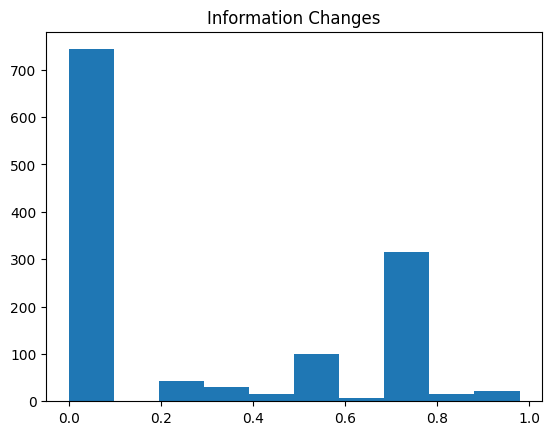

In [59]:
plt.hist(information_changes)
plt.title("Information Changes")

In [45]:
counter_groups.keys()

dict_keys(['foot-wound', 'other-wound', 'healthy-skin', 'ulcer'])

In [60]:
def show_heatmap(key="foot-wound"):    
    df = pd.DataFrame.from_dict(counter_groups[key], orient='index', columns=['count'])
    df = df.reset_index()

    df["x"] = df["index"].apply(lambda x: x[0])
    df["y"] = df["index"].apply(lambda x: x[1])
    heatmap_data = df.pivot_table(index='y', columns='x', values='count')
    heatmap_data.fillna(0, inplace=True)
    sns.heatmap(heatmap_data)

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(key)
    plt.show()


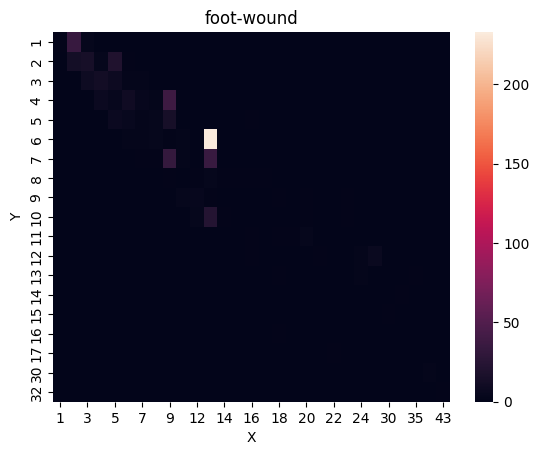

In [61]:
show_heatmap()

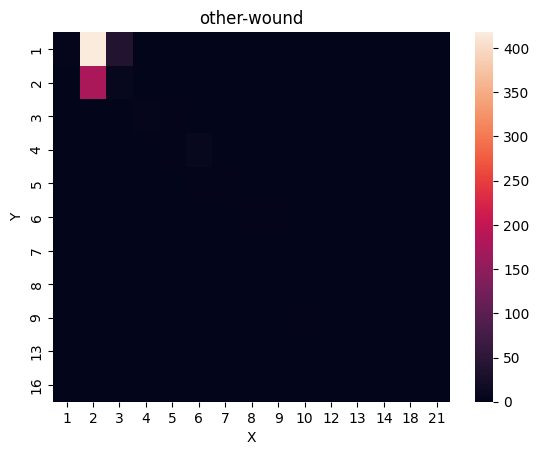

In [62]:
show_heatmap("other-wound")

## Observation

The size of other-wound and foot-wound are extremely different. Even if we use w_hat, h_hat as the idea shape of samples. From the plot of information changes, we will lose more 1/3 (threshold=.5) data.

Several ways are considered here:
- Two phases classification:
    - phase 1: use only small size to train a classification
    - phase 2: split big size image to NxM blocks and filter it with the model from phase1. For each big size image will have 
    {
        image_id: [blck1, bock2,...,blocknm]
    }. 
    Bag of classification finetuning in phase2 

- Data are not well-defined:
    - The model can't learn from phase1. If we simply resize data to same size, the model will learn the size feature which is not what we want. (Simply check with logit regression with size features only. See classification2.py )

- Others:
    - Transformation based methods.